# Sixt Data Science Lab – Bike Sharing Challenge (Solution)

This notebook provides a complete, **reproducible** solution pipeline for the Bike Sharing dataset.

## Contents
1. Environment & Data Loading  
2. Exploratory Data Analysis (EDA)  
3. Feature Engineering  
4. Modeling & Validation (time-aware)  
5. Final Evaluation on Last-30-Day Holdout  
6. Error Analysis & Interpretation  
7. Reflection / Notes

**Files expected**: `day.csv` (mandatory), `hour.csv` (optional). Place them in the same directory as this notebook.  
If `day.csv` is not found locally, the notebook will attempt to download it from the UCI repository (if an internet connection is available).

## 1) Environment & Data Loading

**Split protocol**: As requested by the template, we use the **last 30 calendar days** as a final holdout set.  
All remaining data is used for training/validation with **time-series splits** (no leakage).

In [2]:
import os, warnings
warnings.filterwarnings('ignore')
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
from zipfile import ZipFile
BASE = Path('.')
PLOTS_DAY = BASE/'plots'/'day'; PLOTS_HOUR = BASE/'plots'/'hour'
PLOTS_DAY.mkdir(parents=True, exist_ok=True) 
PLOTS_HOUR.mkdir(parents=True, exist_ok=True)
DAY_CSV = BASE/'day.csv'
HOUR_CSV = BASE/'hour.csv'
def ensure_data():
    if DAY_CSV.exists() and HOUR_CSV.exists(): return
    try:
        print('Attempting UCI download...')
        url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip'
        zip_path, _ = urlretrieve(url)
        with ZipFile(zip_path, 'r') as zf:
            for name in zf.namelist():
                if name.endswith('day.csv') and not DAY_CSV.exists(): zf.extract(name, BASE); os.replace(BASE/name, DAY_CSV)
                if name.endswith('hour.csv') and not HOUR_CSV.exists(): zf.extract(name, BASE); os.replace(BASE/name, HOUR_CSV)
        print('Download complete.')
    except Exception as e:
        print('Data not found and download failed:', e)
ensure_data()
df_day = pd.read_csv(DAY_CSV)
df_hour = pd.read_csv(HOUR_CSV)
df_day['dteday'] = pd.to_datetime(df_day['dteday'])
df_hour['dteday'] = pd.to_datetime(df_hour['dteday'])
df_day = df_day.sort_values('dteday').reset_index(drop=True)
df_hour = df_hour.sort_values(['dteday','hr']).reset_index(drop=True)
print('Day shape:', df_day.shape, '| Hour shape:', df_hour.shape)

Day shape: (731, 16) | Hour shape: (17379, 17)


### Basic sanity checks

In [4]:
#display(df_day.describe(include='all'))
assert 'cnt' in df_day.columns, 'Target `cnt` not found.'
assert df_day['cnt'].ge(0).all(), 'Negative counts found (unexpected).'
print('Date range:', df_day['dteday'].min().date(), '-->', df_day['dteday'].max().date())
print('N days:', len(df_day))

# Check for missing values in day data
missing_day = df_day.isnull().sum()

os.makedirs("results/analysis", exist_ok=True)
print("Missing values in day data:\n", missing_day)
# Save missing values report to a text file
with open("results/analysis/missing_day_report.txt", "w") as f:
    f.write(missing_day.to_string())

# Check for missing values in hour data
missing_hour = df_hour.isnull().sum()

print("\nMissing values in hour data:\n", missing_hour)
# Save missing values report to a text file
with open("results/analysis/missing_hour_report.txt", "w") as f:
    f.write(missing_hour.to_string())

Date range: 2011-01-01 --> 2012-12-31
N days: 731
Missing values in day data:
 instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

Missing values in hour data:
 instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64


## 2) Exploratory Data Analysis (EDA)

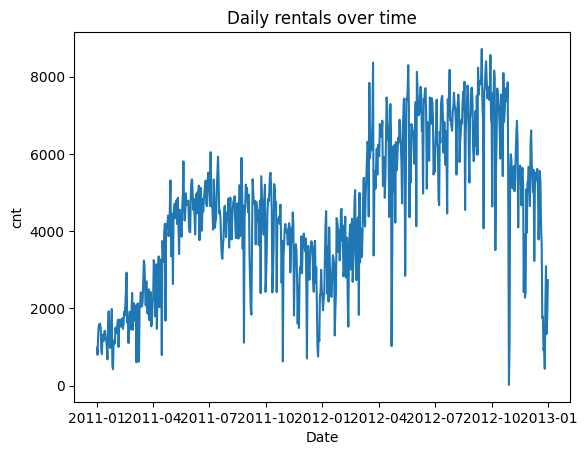

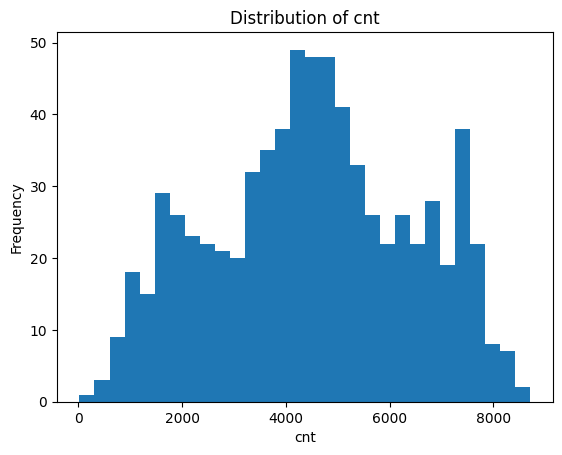

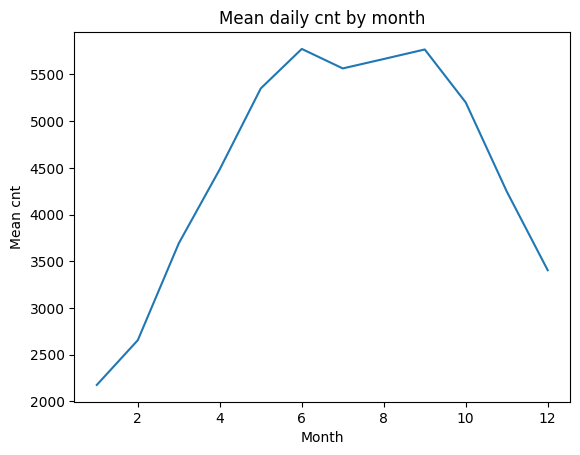

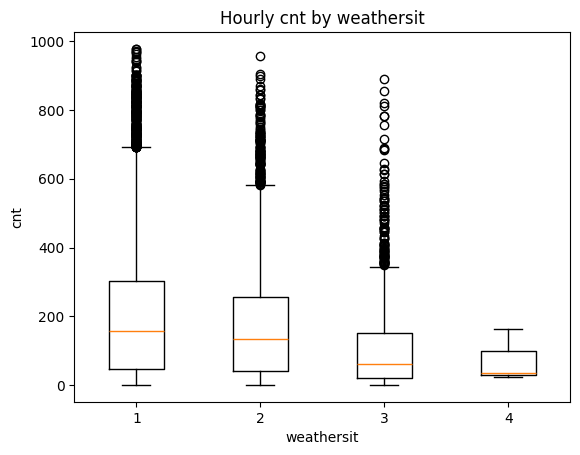

Average cnt by hour:
     hr         cnt
0    0   53.898072
1    1   33.375691
2    2   22.869930
3    3   11.727403
4    4    6.352941
5    5   19.889819
6    6   76.044138
7    7  212.064649
8    8  359.011004
9    9  219.309491
10  10  173.668501
11  11  208.143054
12  12  253.315934
13  13  253.661180
14  14  240.949246
15  15  251.233196
16  16  311.983562
17  17  461.452055
18  18  425.510989
19  19  311.523352
20  20  226.030220
21  21  172.314560
22  22  131.335165
23  23   87.831044


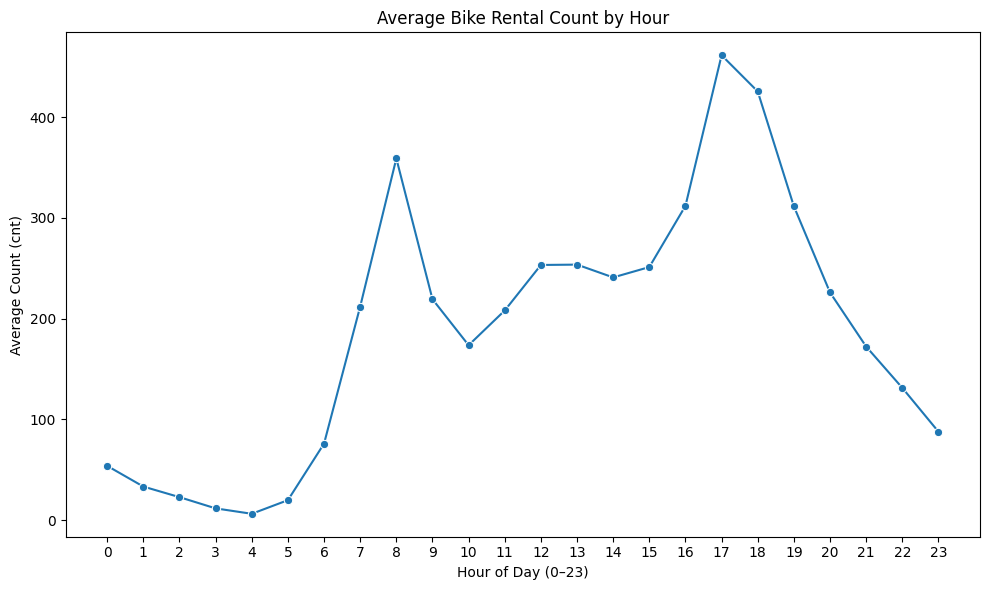

Correlation matrix (day):
                  cnt      temp     atemp       hum  windspeed  weathersit  \
cnt         1.000000  0.404772  0.400929 -0.322911   0.093234   -0.142426   
temp        0.404772  1.000000  0.987672 -0.069881  -0.023125   -0.102640   
atemp       0.400929  0.987672  1.000000 -0.051918  -0.062336   -0.105563   
hum        -0.322911 -0.069881 -0.051918  1.000000  -0.290105    0.418130   
windspeed   0.093234 -0.023125 -0.062336 -0.290105   1.000000    0.026226   
weathersit -0.142426 -0.102640 -0.105563  0.418130   0.026226    1.000000   
workingday  0.030284  0.055390  0.054667  0.015688  -0.011830    0.044672   
hr          0.394071  0.137603  0.133750 -0.276498   0.137252   -0.020203   

            workingday        hr  
cnt           0.030284  0.394071  
temp          0.055390  0.137603  
atemp         0.054667  0.133750  
hum           0.015688 -0.276498  
windspeed    -0.011830  0.137252  
weathersit    0.044672 -0.020203  
workingday    1.000000  0.002285  

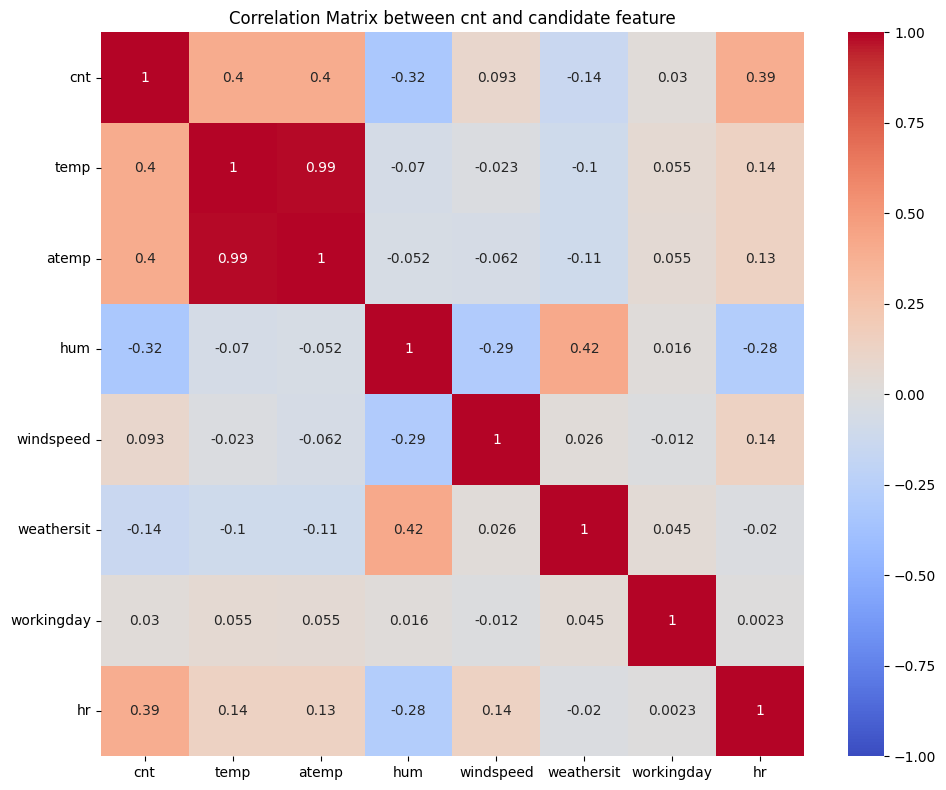

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
# Target over time
plt.figure()
plt.plot(df_day['dteday'], df_day['cnt'])
plt.title('Daily rentals over time')
plt.xlabel('Date')
plt.ylabel('cnt')
plt.show()

# Simple hist of target
plt.figure()
plt.hist(df_day['cnt'], bins=30)
plt.title('Distribution of cnt')
plt.xlabel('cnt')
plt.ylabel('Frequency')
plt.show()

# Seasonal pattern
plt.figure()
monthly = df_day.groupby(df_day['dteday'].dt.month)['cnt'].mean()
plt.plot(monthly.index, monthly.values)
plt.title('Mean daily cnt by month')
plt.xlabel('Month')
plt.ylabel('Mean cnt')
plt.show()


# Weather situation vs cnt (boxplot style via pure matplotlib)
plt.figure()
data = [df_hour.loc[df_hour['weathersit']==k, 'cnt'] for k in sorted(df_hour['weathersit'].unique())]
plt.boxplot(data, labels=sorted(df_hour['weathersit'].unique()))
plt.title('Hourly cnt by weathersit')
plt.xlabel('weathersit')
plt.ylabel('cnt')
plt.show()

# Plot and save average rental count by hour (0–23)
avg_by_hour = df_hour.groupby('hr', as_index=False)['cnt'].mean().sort_values('hr')
print("Average cnt by hour:\n", avg_by_hour)

plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_by_hour, x='hr', y='cnt', marker='o')
plt.xticks(range(24))
plt.xlabel('Hour of Day (0–23)')
plt.ylabel('Average Count (cnt)')
plt.title('Average Bike Rental Count by Hour')
plt.tight_layout()
plt.savefig('results/analysis/count_by_hour.png')
plt.show()
plt.close()

# Define a list of candidate feature columns
candid_cols = ['temp', 'atemp', 'hum', 'windspeed', 'weathersit', 'workingday', 'hr']

# Compute and print the correlation matrix between cnt and weather features
cols_for_corr_day = ['cnt'] + candid_cols
corr_matrix_day = df_hour[cols_for_corr_day].corr()
print("Correlation matrix (day):\n", corr_matrix_day)

# Plot and save the correlation matrix heatmap
import os
import matplotlib.pyplot as plt
import seaborn as sns

os.makedirs("results/analysis", exist_ok=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_day, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix between cnt and candidate feature')
plt.tight_layout()
plt.savefig('results/analysis/correlation_matrix.png')
plt.show()
plt.close()

nmax (max bikes needed on any day): 727
n95 (95th-percentile bikes needed): 632


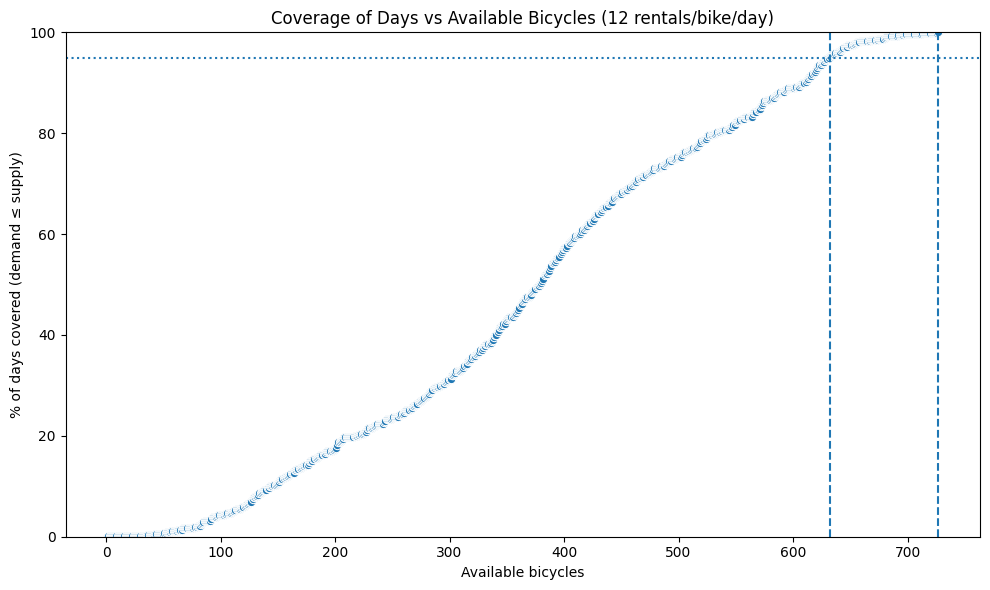

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

os.makedirs("results/analysis", exist_ok=True)

MAX_RENTS_PER_BIKE_PER_DAY = 12

# Work on daily data
dfd = df_day.sort_values("dteday").copy()
dfd["bikes_needed"] = np.ceil(dfd["cnt"] / MAX_RENTS_PER_BIKE_PER_DAY).astype(int)

# nmax (max bikes needed on any day)
nmax = int(dfd["bikes_needed"].max())

# n95 (95th percentile bikes needed) – minimal integer covering ≥95% of days
n95 = int(np.quantile(dfd["bikes_needed"], 0.95, method="higher"))

print(f"nmax (max bikes needed on any day): {nmax}")
print(f"n95 (95th-percentile bikes needed): {n95}")

# Coverage curve: for each available bike count n, what % of days are covered?
n_vals = np.arange(1, nmax + 1)
coverage = (dfd["bikes_needed"].to_numpy()[None, :] <= n_vals[:, None]).mean(axis=1) * 100.0
coverage_df = pd.DataFrame({"bikes_available": n_vals, "pct_days_covered": coverage})
coverage_df.to_csv("results/analysis/bike_coverage_curve.csv", index=False)

# Plot coverage vs available bikes
plt.figure(figsize=(10, 6))
sns.lineplot(data=coverage_df, x="bikes_available", y="pct_days_covered", marker="o")
plt.axvline(n95, linestyle="--")
plt.axhline(95, linestyle=":")
plt.axvline(nmax, linestyle="--")
plt.ylim(0, 100)
plt.xlabel("Available bicycles")
plt.ylabel("% of days covered (demand ≤ supply)")
plt.title("Coverage of Days vs Available Bicycles (12 rentals/bike/day)")
plt.tight_layout()
plt.savefig("results/analysis/bike_coverage_curve.png")
plt.show()
plt.close()

## 3) Feature Engineering

We create lag and rolling features (to capture serial dependence) and standard calendar encodings.  
Categoricals (`season`, `weathersit`, `mnth`, `weekday`, `yr`, `holiday`, `workingday`) are one-hot encoded by the model pipeline.

In [16]:
def fe_day(df):
    df = df.copy()
    # Calendar
    df['dow']=df['dteday'].dt.dayofweek
    df['weekofyear']=df['dteday'].dt.isocalendar().week.astype(int)
    # Lags
    for lag in [1,7]: 
        df[f'cnt_lag{lag}']=df['cnt'].shift(lag)
    # Rolling
    df['cnt_roll7_mean']=df['cnt'].rolling(7).mean()
    df['cnt_roll7_std']=df['cnt'].rolling(7).std()
    # Interaction-ish nonlinearities
    df['temp2']=df['temp']**2
    df['hum2']=df['hum']**2
    df['windspeed2']=df['windspeed']**2
    # Drop rows with NaNs introduced by lags/rolling
    return df.dropna().reset_index(drop=True)
def fe_hour(df):
    df=df.copy()
    # Calendar
    df['dow']=df['dteday'].dt.dayofweek
    hr=df['hr'].astype(float)
    import numpy as np
    # Lags
    df['hr_sin']=np.sin(2*np.pi*hr/24)
    df['hr_cos']=np.cos(2*np.pi*hr/24)
    for lag in [1,24,168]: 
        df[f'cnt_lag{lag}']=df['cnt'].shift(lag)
    # Rolling
    df['cnt_roll24_mean']=df['cnt'].rolling(24).mean()
    df['cnt_roll24_std']=df['cnt'].rolling(24).std()
    df['cnt_roll168_mean']=df['cnt'].rolling(168).mean()
    df['cnt_roll168_std']=df['cnt'].rolling(168).std()
    # Adding nonlinearities to help linear models
    df['temp2']=df['temp']**2
    df['hum2']=df['hum']**2
    df['windspeed2']=df['windspeed']**2
    # Drop rows with NaNs introduced by lags/rolling
    return df.dropna().reset_index(drop=True)

# Feature set used for learning a linear model (ridge)
def get_feature_cols_ls(df):
    return [c for c in df.columns if c not in ['cnt','dteday','instant','casual','registered', 'registered', 'yr']]

# Feature set used for learning tree-based models (lgbm & xgboost)
def get_feature_cols_gb(df):
    # Exact columns to drop
    drop_exact = {'cnt', 'dteday', 'instant', 'casual', 'registered', 'yr'}

    # Any column whose name ends with one of these will be removed
    drop_suffixes = ('2', 'sin', 'cos')

    cols = []
    for c in df.columns:
        if c in drop_exact:
            continue
        if c.endswith(drop_suffixes):  
            continue
        cols.append(c)
    return cols

# Feature set used for learning lstm model
def get_feature_cols_lstm(df):
    # Exact columns to drop
    drop_exact = {'dteday', 'instant', 'casual', 'registered', 'yr'} # No leakage since window only contains past history

    # Any column whose name starts with one of these will be removed
    drop_prefixes = ('cnt_lag', 'cnt_roll')
    # Any column whose name ends with one of these will be removed
    drop_suffixes = ('2', 'sin', 'cos')
    cols = []
    for c in df.columns:
        if c in drop_exact:
            continue
        if c.startswith(drop_prefixes):   
            continue
        if c.endswith(drop_suffixes):  
            continue
        cols.append(c)
    return cols


### Train/Validation/Test split
- **Test** = last 30 calendar days (per instructions)
- **Train/Val** = remaining, evaluated via time-series cross-validation

In [8]:
"""def split_day(df):
    import pandas as pd
    last_30=df['dteday'].max()-pd.Timedelta(days=29)
    m=df['dteday']>=last_30
    return df.loc[~m].copy(), df.loc[m].copy()
def split_hour(df):
    import pandas as pd
    last_7=df['dteday'].max()-pd.Timedelta(days=6)
    m=df['dteday']>=last_7
    return df.loc[~m].copy(), df.loc[m].copy()"""



"def split_day(df):\n    import pandas as pd\n    last_30=df['dteday'].max()-pd.Timedelta(days=29)\n    m=df['dteday']>=last_30\n    return df.loc[~m].copy(), df.loc[m].copy()\ndef split_hour(df):\n    import pandas as pd\n    last_7=df['dteday'].max()-pd.Timedelta(days=6)\n    m=df['dteday']>=last_7\n    return df.loc[~m].copy(), df.loc[m].copy()"

In [7]:
df_aug_day = fe_day(df_day)

# Identify last 30 days in the *original* timeline
last_30_start_date = df_day['dteday'].max() - pd.Timedelta(days=29)


mask_test_day = df_aug_day['dteday'] >= last_30_start_date
df_trainval_day = df_aug_day.loc[~mask_test_day].copy()
df_test_day = df_aug_day.loc[mask_test_day].copy()

print('Train/Val size using day.csv:', df_trainval_day.shape, '| Test size:', df_test_day.shape)


df_aug_hour = fe_hour(df_hour)


mask_test_hour = df_aug_hour['dteday'] >= last_30_start_date
df_trainval_hour = df_aug_hour.loc[~mask_test_hour].copy()
df_test_hour = df_aug_hour.loc[mask_test_hour].copy()

print('Train/Val size using hour.csv:', df_trainval_hour.shape, '| Test size:', df_test_hour.shape)

Train/Val size using day.csv: (694, 25) | Test size: (30, 25)
Train/Val size using hour.csv: (16493, 30) | Test size: (718, 30)


ridge_day CV RMSE: [728.98 920.84]
Test RMSE: 714974.06
Test MAE: 678.66
Test R^2: 0.777
Test MAPE*: 28.54%


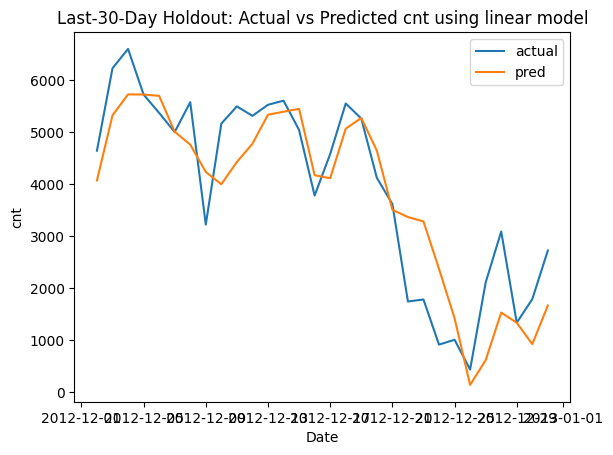

In [21]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor


X_cols_day = get_feature_cols_ls(df_trainval_day)
y_col_day = 'cnt'

numeric_features_day = df_trainval_day[X_cols_day].select_dtypes(include=[np.number]).columns.tolist()
categorical_features_day = [c for c in df_trainval_day[X_cols_day].columns if c not in numeric_features_day]

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_day),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_day)
    ]
)

ridge_model_day = Ridge(alpha=10.0, random_state=42)
cv_results = {}
pipe = Pipeline(steps=[('prep', preprocess), ('model', ridge_model_day)])
# negative RMSE (sklearn returns neg MSE by default for scoring='neg_root_mean_squared_error')
tscv = TimeSeriesSplit(n_splits=2)
scores = cross_val_score(pipe,
                            df_trainval_day[X_cols_day], df_trainval_day[y_col_day],
                            scoring='neg_root_mean_squared_error',
                            cv=tscv,
                            n_jobs=None)
cv_results['ridge_day'] = -scores  # make positive
print('ridge_day', 'CV RMSE:', np.round(-scores, 2))

#Train the pipeline on all trainval data
pipe.fit(df_trainval_day[X_cols_day], df_trainval_day[y_col_day])

# Assess performance over test data
y_hat = pipe.predict(df_test_day[X_cols_day])
y_true = df_test_day[y_col_day].values

def metrics(y, y_pred):
    rmse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    mape = np.mean(np.abs((y - y_pred) / np.maximum(1, np.abs(y)))) * 100.0
    return rmse, mae, r2, mape

rmse, mae, r2, mape = metrics(y_true, y_hat)
print(f'Test RMSE: {rmse:.2f}\nTest MAE: {mae:.2f}\nTest R^2: {r2:.3f}\nTest MAPE*: {mape:.2f}%')
res = df_test_day[['dteday','cnt']].copy()
res['pred'] = y_hat
res.head()

import matplotlib.pyplot as plt

plt.figure()
plt.plot(res['dteday'], res['cnt'], label='actual')
plt.plot(res['dteday'], res['pred'], label='pred')
plt.title('Last-30-Day Holdout: Actual vs Predicted cnt using linear model')
plt.xlabel('Date')
plt.ylabel('cnt')
plt.legend()
plt.show()

ridge_hour CV RMSE: [68.77 88.87]
Daily RMSE (aggregated from hourly preds): 285232.14


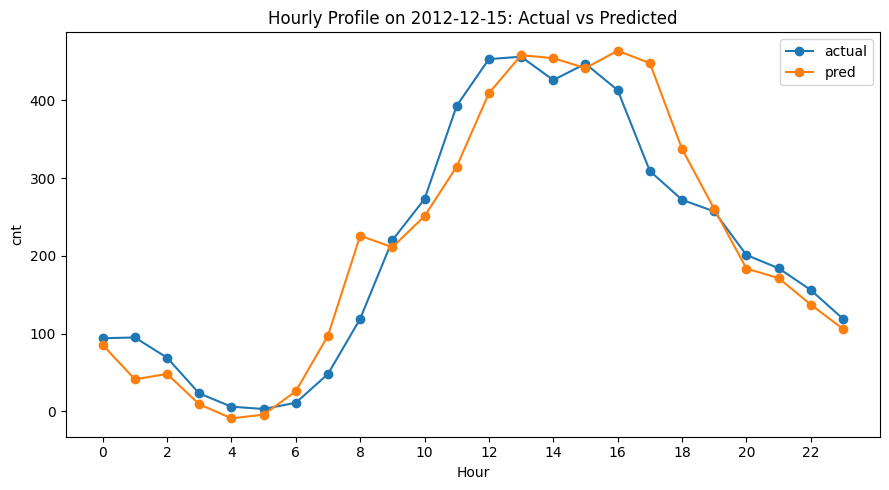

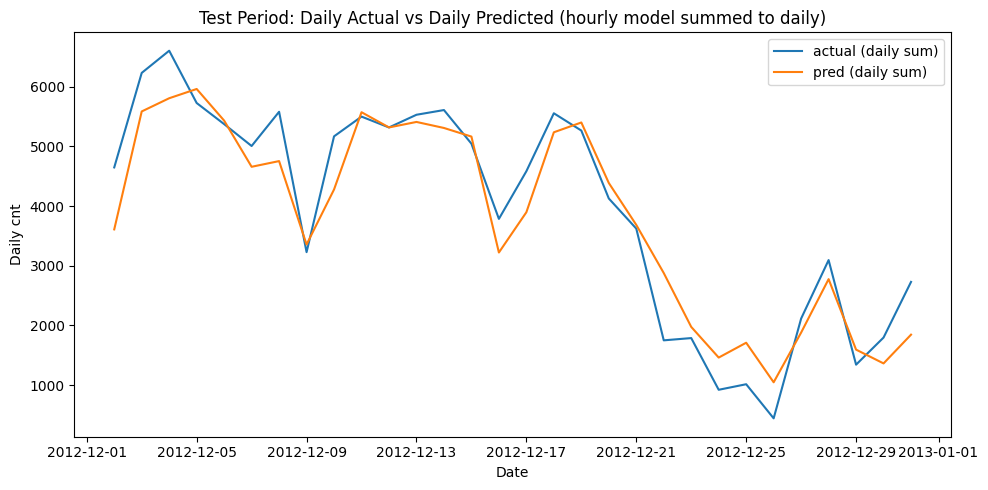

In [27]:

X_cols_hour = get_feature_cols_ls(df_trainval_hour)
y_col_hour = 'cnt'

numeric_features_hour = df_trainval_hour[X_cols_hour].select_dtypes(include=[np.number]).columns.tolist()
categorical_features_hour = [c for c in df_trainval_hour[X_cols_hour].columns if c not in numeric_features_hour]

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_hour),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_hour)
    ]
)

ridge_model_hour = Ridge(alpha=10.0, random_state=42)
pipe = Pipeline(steps=[('prep', preprocess), ('model', ridge_model_hour)])
# negative RMSE (sklearn returns neg MSE by default for scoring='neg_root_mean_squared_error')
tscv = TimeSeriesSplit(n_splits=2)
scores = cross_val_score(pipe,
                            df_trainval_hour[X_cols_hour], df_trainval_hour[y_col_hour],
                            scoring='neg_root_mean_squared_error',
                            cv=tscv,
                            n_jobs=None)
cv_results['ridge_hour'] = -scores  # make positive
print('ridge_hour', 'CV RMSE:', np.round(-scores, 2))

#Train the pipeline on all trainval data
pipe.fit(df_trainval_hour[X_cols_hour], df_trainval_hour[y_col_hour])

# Assumptions:
# - pipe is your *fitted* Pipeline (prep + Ridge) trained on hourly data
# - df_test_hour is your hourly test DataFrame
# - X_cols_hour is the feature list used for training (no leakage cols)
# - y_col_hour = 'cnt'
y_col_hour = 'cnt'
os.makedirs("results/analysis", exist_ok=True)

# Ensure datetime dtype
df_test_hour = df_test_hour.copy()
df_test_hour['dteday'] = pd.to_datetime(df_test_hour['dteday'])

# Predict on the test set (hourly)
y_hat_te = pipe.predict(df_test_hour[X_cols_hour])
res_hour = df_test_hour[['dteday', 'hr', y_col_hour]].copy()
res_hour['pred'] = y_hat_te


# (optional) quick daily RMSE on the aggregated series
from sklearn.metrics import mean_squared_error
daily_rmse = mean_squared_error(daily_cmp[y_col_hour], daily_cmp['pred'])
print(f"Daily RMSE (aggregated from hourly preds): {daily_rmse:.2f}")

# ---------------------------
# (1) For a specific date: actual vs predicted (hourly profile, 0–23)
# ---------------------------
# Choose a date inside the test set; replace below with your desired date
target_date = pd.to_datetime('2012-12-15')
if target_date.date() not in set(res_hour['dteday'].dt.date):
    # fallback: use the first date in test if your chosen date isn't present
    target_date = res_hour['dteday'].iloc[0].normalize()

day_profile = res_hour.loc[res_hour['dteday'].dt.normalize() == target_date].sort_values('hr')

plt.figure(figsize=(9, 5))
plt.plot(day_profile['hr'], day_profile[y_col_hour], label='actual', marker='o')
plt.plot(day_profile['hr'], day_profile['pred'], label='pred', marker='o')
plt.xticks(range(0, 24, 2))
plt.xlabel('Hour')
plt.ylabel('cnt')
plt.title(f'Hourly Profile on {target_date.date()}: Actual vs Predicted')
plt.legend()
plt.tight_layout()
plt.savefig(f"results/analysis/hourly_profile_{target_date.date()}.png")
plt.show()
plt.close()

# ---------------------------
# (2) Aggregate hourly → daily: compare daily actual vs daily predicted
# ---------------------------
daily_cmp = res_hour.groupby('dteday', as_index=False)[[y_col_hour, 'pred']].sum()

plt.figure(figsize=(10, 5))
plt.plot(daily_cmp['dteday'], daily_cmp[y_col_hour], label='actual (daily sum)')
plt.plot(daily_cmp['dteday'], daily_cmp['pred'], label='pred (daily sum)')
plt.xlabel('Date')
plt.ylabel('Daily cnt')
plt.title('Test Period: Daily Actual vs Daily Predicted (hourly model summed to daily)')
plt.legend()
plt.tight_layout()
plt.savefig("results/analysis/daily_from_hourly_actual_vs_pred.png")
plt.show()
plt.close()


In [1]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from lightgbm import LGBMRegressor
import numpy as np
import matplotlib.pyplot as plt

# ----- Feature set -----
X_cols_day = get_feature_cols_gb(df_trainval_day)   # keep same naming pattern as your ridge code
y_col_day = 'cnt'

numeric_features_day = df_trainval_day[X_cols_day].select_dtypes(include=[np.number]).columns.tolist()
categorical_features_day = [c for c in df_trainval_day[X_cols_day].columns if c not in numeric_features_day]

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_day),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_day)
    ]
)

# ----- Model & CV -----
lgbm_model_day = LGBMRegressor(
    random_state=42,
    n_estimators=600,
    learning_rate=0.05
)
cv_results = {}
pipe = Pipeline(steps=[('prep', preprocess), ('model', lgbm_model_day)])

# negative RMSE (sklearn returns neg values for 'neg_root_mean_squared_error')
tscv = TimeSeriesSplit(n_splits=2)
scores = cross_val_score(
    pipe,
    df_trainval_day[X_cols_day], df_trainval_day[y_col_day],
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    n_jobs=None
)
cv_results['lgbm_day'] = -scores  # make positive
print('lgbm_day', 'CV RMSE:', np.round(-scores, 2))

# ----- Train on all trainval -----
pipe.fit(df_trainval_day[X_cols_day], df_trainval_day[y_col_day])

# ----- Test evaluation -----
y_hat = pipe.predict(df_test_day[X_cols_day])
y_true = df_test_day[y_col_day].values

def metrics(y, y_pred):
    rmse = mean_squared_error(y, y_pred)  # RMSE
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    mape = np.mean(np.abs((y - y_pred) / np.maximum(1, np.abs(y)))) * 100.0
    return rmse, mae, r2, mape

rmse, mae, r2, mape = metrics(y_true, y_hat)
print(f'Test RMSE: {rmse:.2f}\nTest MAE: {mae:.2f}\nTest R^2: {r2:.3f}\nTest MAPE*: {mape:.2f}%')

# ----- Plot -----
res = df_test_day[['dteday', 'cnt']].copy()
res['pred'] = y_hat

plt.figure()
plt.plot(res['dteday'], res['cnt'], label='actual')
plt.plot(res['dteday'], res['pred'], label='pred')
plt.title('Last-30-Day Holdout: Actual vs Predicted cnt using LGBM model')
plt.xlabel('Date')
plt.ylabel('cnt')
plt.legend()
plt.show()


NameError: name 'get_feature_cols_gb' is not defined

xgb_day CV RMSE: [1300.62 1213.79]
Test RMSE: 644487.31  MAE: 675.26  R^2: 0.799  MAPE*: 28.42%


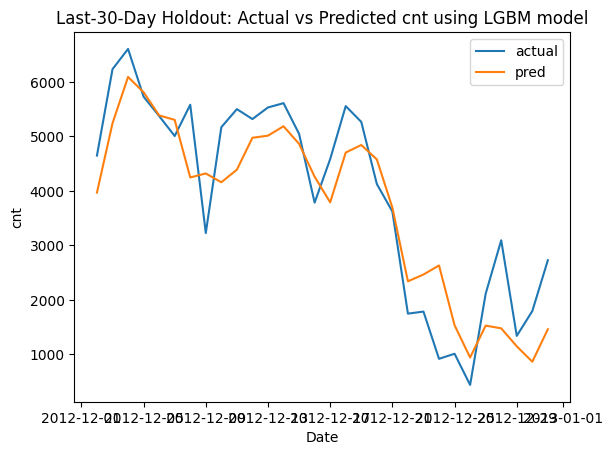

In [13]:
from xgboost import XGBRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# ---- features/target (same pattern as your ridge code) ----
X_cols_day = get_feature_cols_ls(df_trainval_day)
y_col_day = 'cnt'

numeric_features_day = df_trainval_day[X_cols_day].select_dtypes(include=[np.number]).columns.tolist()
categorical_features_day = [c for c in df_trainval_day[X_cols_day].columns if c not in numeric_features_day]

preprocess = ColumnTransformer([
    ('num', StandardScaler(), numeric_features_day),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_day)
])

# ---- minimal XGBoost pipeline, CV, fit, predict ----
xgb_model_day = XGBRegressor(
    random_state=42,
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    objective='reg:squarederror',
    tree_method='hist'
)

pipe = Pipeline([('prep', preprocess), ('model', xgb_model_day)])

tscv = TimeSeriesSplit(n_splits=2)
scores = cross_val_score(
    pipe,
    df_trainval_day[X_cols_day], df_trainval_day[y_col_day],
    scoring='neg_root_mean_squared_error',
    cv=tscv
)
print('xgb_day CV RMSE:', np.round(-scores, 2))

pipe.fit(df_trainval_day[X_cols_day], df_trainval_day[y_col_day])
y_hat = pipe.predict(df_test_day[X_cols_day])
y_true = df_test_day[y_col_day].values

rmse = mean_squared_error(y_true, y_hat)
mae  = mean_absolute_error(y_true, y_hat)
r2   = r2_score(y_true, y_hat)
mape = np.mean(np.abs((y_true - y_hat) / np.maximum(1, np.abs(y_true)))) * 100.0
print(f'Test RMSE: {rmse:.2f}  MAE: {mae:.2f}  R^2: {r2:.3f}  MAPE*: {mape:.2f}%')


# ----- Plot -----
res = df_test_day[['dteday', 'cnt']].copy()
res['pred'] = y_hat

plt.figure()
plt.plot(res['dteday'], res['cnt'], label='actual')
plt.plot(res['dteday'], res['pred'], label='pred')
plt.title('Last-30-Day Holdout: Actual vs Predicted cnt using LGBM model')
plt.xlabel('Date')
plt.ylabel('cnt')
plt.legend()
plt.show()


In [18]:
X_cols_day = get_feature_cols_lstm(df_trainval_day)
print("X_cols_day:", X_cols_day)

X_cols_day: ['season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt', 'dow', 'weekofyear']


epoch 001/020 | train_loss=13972341.63303 | val_RMSE=4141.636
epoch 002/020 | train_loss=13836207.43119 | val_RMSE=4123.234
epoch 003/020 | train_loss=13705123.65138 | val_RMSE=4105.551
epoch 004/020 | train_loss=13578241.17431 | val_RMSE=4088.062
epoch 005/020 | train_loss=13453341.89908 | val_RMSE=4070.924
epoch 006/020 | train_loss=13332806.44266 | val_RMSE=4053.864
epoch 007/020 | train_loss=13213499.23853 | val_RMSE=4037.401
epoch 008/020 | train_loss=13095743.68807 | val_RMSE=4020.743
epoch 009/020 | train_loss=12979094.04587 | val_RMSE=4004.172
epoch 010/020 | train_loss=12862761.76147 | val_RMSE=3987.710
epoch 011/020 | train_loss=12747030.24771 | val_RMSE=3971.117
epoch 012/020 | train_loss=12632626.47248 | val_RMSE=3954.772
epoch 013/020 | train_loss=12520647.08257 | val_RMSE=3938.497
epoch 014/020 | train_loss=12409083.27523 | val_RMSE=3922.275
epoch 015/020 | train_loss=12297806.40367 | val_RMSE=3906.111
epoch 016/020 | train_loss=12187083.01835 | val_RMSE=3889.990
epoch 01

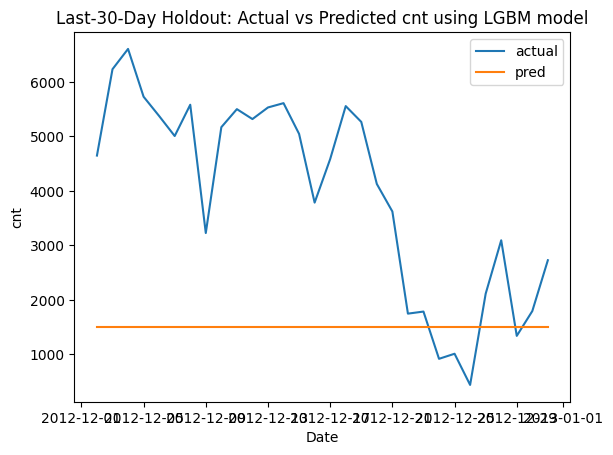

In [19]:
# ------- Minimal LSTM training (no tqdm; simple per-epoch prints) -------
import numpy as np
import torch, torch.nn as nn
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1) Features/target (same naming)
X_cols_day = get_feature_cols_lstm(df_trainval_day)
y_col_day  = 'cnt'

numeric_features_day     = df_trainval_day[X_cols_day].select_dtypes(include=[np.number]).columns.tolist()
categorical_features_day = [c for c in df_trainval_day[X_cols_day].columns if c not in numeric_features_day]

preprocess = ColumnTransformer([
    ('num', StandardScaler(), numeric_features_day),
    # use dense output for LSTM
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features_day)  # sklearn>=1.2
    # if older sklearn, use: OneHotEncoder(handle_unknown='ignore', sparse=False)
])

# 2) Helper: make sliding windows for LSTM
L = 14  # context length for daily data
def to_sequences(X2d, y1d, L):
    if hasattr(X2d, "toarray"):  # in case transformer yields sparse
        X2d = X2d.toarray()
    Xs, ys = [], []
    for i in range(L, len(X2d)):
        Xs.append(X2d[i-L:i, :])
        ys.append(y1d[i])
    return np.stack(Xs), np.array(ys, dtype=np.float32)

# 3) Tiny LSTM regressor
class LSTMReg(nn.Module):
    def __init__(self, n_features, hidden=64):
        super().__init__()
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=hidden, batch_first=True)
        self.fc   = nn.Linear(hidden, 1)
    def forward(self, x):
        out, _ = self.lstm(x)           # [B, L, H]
        yhat = self.fc(out[:, -1, :])   # [B, 1]
        return yhat.squeeze(-1)

def fit_lstm(Xtr_seq, ytr_seq, Xval_seq=None, yval_seq=None, epochs=60, lr=1e-2, batch=8, print_every=1):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = LSTMReg(n_features=Xtr_seq.shape[-1]).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    lossf = torch.nn.MSELoss()

    Xtr_t = torch.tensor(Xtr_seq, dtype=torch.float32, device=device)
    ytr_t = torch.tensor(ytr_seq, dtype=torch.float32, device=device)
    if Xval_seq is not None:
        Xval_t = torch.tensor(Xval_seq, dtype=torch.float32, device=device)
        yval_t = torch.tensor(yval_seq, dtype=torch.float32, device=device)

    for ep in range(epochs):
        model.train()
        idx = np.random.permutation(len(Xtr_t))
        epoch_loss = 0.0; n_seen = 0
        for s in range(0, len(idx), batch):
            b = idx[s:s+batch]
            opt.zero_grad()
            pred = model(Xtr_t[b])
            loss = lossf(pred, ytr_t[b])
            loss.backward(); opt.step()
            epoch_loss += float(loss.item()) * len(b); n_seen += len(b)

        if (ep + 1) % print_every == 0:
            if Xval_seq is not None:
                model.eval()
                with torch.no_grad():
                    val_rmse = float(torch.sqrt(lossf(model(Xval_t), yval_t)).item())
                print(f"epoch {ep+1:03d}/{epochs:03d} | train_loss={epoch_loss/n_seen:.5f} | val_RMSE={val_rmse:.3f}")
            else:
                print(f"epoch {ep+1:03d}/{epochs:03d} | train_loss={epoch_loss/n_seen:.5f}")

    return model

# 4) TimeSeries CV (manual, analogous to cross_val_score) — with visible per-epoch prints
tscv = TimeSeriesSplit(n_splits=2)
cv_rmse = []
y_all = df_trainval_day[y_col_day].to_numpy().astype(np.float32)

for tr_idx, va_idx in tscv.split(df_trainval_day):
    X_tr_raw = df_trainval_day.iloc[tr_idx][X_cols_day]
    X_va_raw = df_trainval_day.iloc[va_idx][X_cols_day]
    y_tr     = y_all[tr_idx]
    y_va     = y_all[va_idx]

    # fit preprocess on train fold only
    X_tr = preprocess.fit_transform(X_tr_raw)
    X_va = preprocess.transform(X_va_raw)

    # build sequences; seed validation with last L steps from training to give history
    Xtr_seq, ytr_seq = to_sequences(X_tr, y_tr, L)
    Xva_seq, yva_seq = to_sequences(
        np.vstack([X_tr[-L:], X_va]),
        np.hstack([y_tr[-L:], y_va]),
        L
    )

    # pass validation tensors so progress prints per epoch
    model = fit_lstm(Xtr_seq, ytr_seq, Xval_seq=Xva_seq, yval_seq=yva_seq, epochs=20, print_every=1)

    model.eval()
    with torch.no_grad():
        y_pred_va = model(torch.tensor(Xva_seq, dtype=torch.float32)).cpu().numpy()

    rmse = mean_squared_error(yva_seq, y_pred_va)
    cv_rmse.append(rmse)

print('lstm_day CV RMSE:', np.round(cv_rmse, 2))

# 5) Train on all trainval, then test (prints train loss each epoch)
X_tr_full = preprocess.fit_transform(df_trainval_day[X_cols_day])
y_tr_full = df_trainval_day[y_col_day].to_numpy().astype(np.float32)
Xtr_seq, ytr_seq = to_sequences(X_tr_full, y_tr_full, L)
model = fit_lstm(Xtr_seq, ytr_seq, epochs=30, print_every=1)  # no val -> prints train_loss only

# Prepare test sequences (seed with last L of train)
X_te_raw = df_test_day[X_cols_day]
y_true   = df_test_day[y_col_day].to_numpy().astype(np.float32)
X_te     = preprocess.transform(X_te_raw)
Xte_seq, yte_seq = to_sequences(
    np.vstack([X_tr_full[-L:], X_te]),
    np.hstack([y_tr_full[-L:], y_true]),
    L
)

model.eval()
with torch.no_grad():
    y_hat = model(torch.tensor(Xte_seq, dtype=torch.float32)).cpu().numpy()

rmse = mean_squared_error(y_true, y_hat)  # 
mae  = mean_absolute_error(y_true, y_hat)
r2   = r2_score(y_true, y_hat)
mape = np.mean(np.abs((y_true - y_hat) / np.maximum(1, np.abs(y_true)))) * 100.0
print(f'Test RMSE: {rmse:.2f}  MAE: {mae:.2f}  R^2: {r2:.3f}  MAPE*: {mape:.2f}%')

# ----- Plot -----
res = df_test_day[['dteday', 'cnt']].copy()
res['pred'] = y_hat

plt.figure()
plt.plot(res['dteday'], res['cnt'], label='actual')
plt.plot(res['dteday'], res['pred'], label='pred')
plt.title('Last-30-Day Holdout: Actual vs Predicted cnt using LGBM model')
plt.xlabel('Date')
plt.ylabel('cnt')
plt.legend()
plt.show()

## 4) Modeling & Validation

We use a **time-aware** pipeline with `TimeSeriesSplit`.  
Models tried:
- Ridge Regression (strong baseline with linear effects)
- Random Forest Regressor (nonlinear, robust)
- HistGradientBoostingRegressor (fast boosted trees in scikit-learn)

We select the best based on **cross-validated RMSE**.

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

numeric_features = df_trainval[X_cols].select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in df_trainval[X_cols].columns if c not in numeric_features]

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

models = {
    'ridge': Ridge(alpha=10.0, random_state=42),
    'rf': RandomForestRegressor(n_estimators=400, max_depth=None, random_state=42, n_jobs=-1),
    'hgb': HistGradientBoostingRegressor(max_depth=None, learning_rate=0.1, max_iter=500, random_state=42)
}

tscv = TimeSeriesSplit(n_splits=5)

cv_results = {}
for name, model in models.items():
    pipe = Pipeline(steps=[('prep', preprocess), ('model', model)])
    # negative RMSE (sklearn returns neg MSE by default for scoring='neg_root_mean_squared_error')
    scores = cross_val_score(pipe,
                             df_trainval[X_cols], df_trainval[y_col],
                             scoring='neg_root_mean_squared_error',
                             cv=tscv,
                             n_jobs=None)
    cv_results[name] = -scores  # make positive
    print(name, 'CV RMSE:', np.round(-scores, 2))

cv_summary = pd.DataFrame({k: v for k, v in cv_results.items()})
cv_summary.index = [f'fold_{i+1}' for i in range(len(cv_summary))]
cv_summary.loc['mean'] = cv_summary.mean()
cv_summary.loc['std'] = cv_summary.std()
cv_summary

ridge CV RMSE: [1314.2   630.34  802.3   835.97  911.38]
rf CV RMSE: [ 593.08  910.59 1211.76  972.53 1008.67]
hgb CV RMSE: [ 627.45  989.69 1392.9  1008.93  954.18]


,ridge,rf,hgb
fold_1,1314.203526,593.080206,627.454097
fold_2,630.343725,910.585912,989.686483
fold_3,802.297718,1211.764768,1392.897033
fold_4,835.965403,972.531587,1008.933841
fold_5,911.384204,1008.673481,954.177871
mean,898.838915,939.327191,994.629865
std,227.177504,200.422907,243.022709


### Fit best model on Train/Val and evaluate on Test (last 30 days)

In [ ]:
best_name = cv_summary.loc['mean'].astype(float).idxmin()
print('Selected model:', best_name)
best_model = models[best_name]
final_pipe = Pipeline(steps=[('prep', preprocess), ('model', best_model)])
final_pipe.fit(df_trainval[X_cols], df_trainval[y_col])

y_hat = final_pipe.predict(df_test[X_cols])
y_true = df_test[y_col].values

def metrics(y, y_pred):
    rmse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    mape = np.mean(np.abs((y - y_pred) / np.maximum(1, np.abs(y)))) * 100.0
    return rmse, mae, r2, mape

rmse, mae, r2, mape = metrics(y_true, y_hat)
print(f'Test RMSE: {rmse:.2f}\nTest MAE: {mae:.2f}\nTest R^2: {r2:.3f}\nTest MAPE*: {mape:.2f}%')
res = df_test[['dteday','cnt']].copy()
res['pred'] = y_hat
res.head()




Selected model: ridge
Test RMSE: 582913.68
Test MAE: 598.18
Test R^2: 0.818
Test MAPE*: 26.80%


,dteday,cnt,pred
694,2012-12-02,4649,4403.214986
695,2012-12-03,6234,5653.081163
696,2012-12-04,6606,6014.728102
697,2012-12-05,5729,5930.546085
698,2012-12-06,5375,5754.458515


*Note: MAPE uses a floor of 1 on the denominator to avoid division by zero on very small counts.*

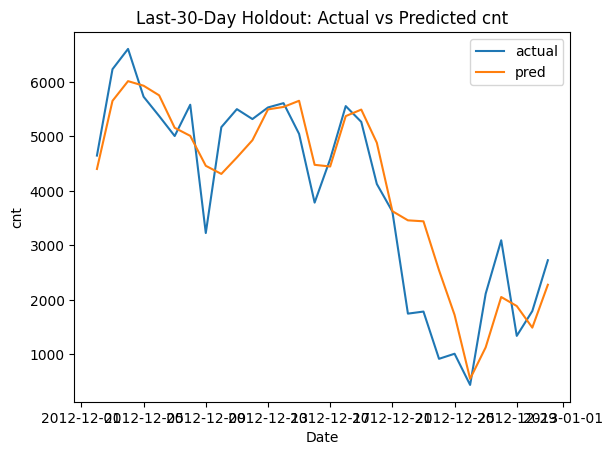

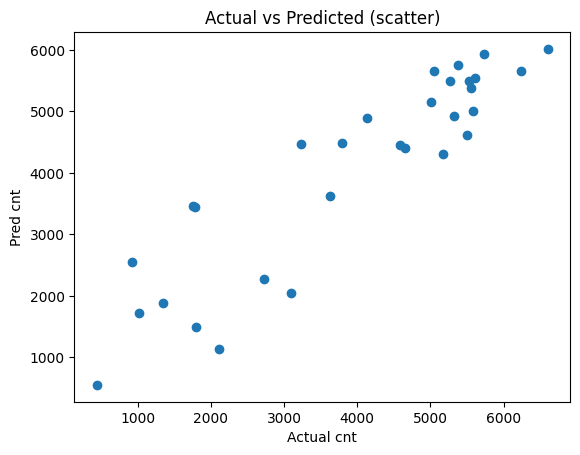

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(res['dteday'], res['cnt'], label='actual')
plt.plot(res['dteday'], res['pred'], label='pred')
plt.title('Last-30-Day Holdout: Actual vs Predicted cnt')
plt.xlabel('Date')
plt.ylabel('cnt')
plt.legend()
plt.show()

plt.figure()
plt.scatter(res['cnt'], res['pred'])
plt.title('Actual vs Predicted (scatter)')
plt.xlabel('Actual cnt')
plt.ylabel('Pred cnt')
plt.show()

## 5) Error Analysis & Interpretation

We check permutation importances for tree-based models (or coefficients for Ridge).

In [11]:
from sklearn.inspection import permutation_importance

if best_name in ['rf','hgb']:
    r = permutation_importance(final_pipe, df_trainval[X_cols], df_trainval[y_col],
                               n_repeats=5, random_state=42, scoring='neg_root_mean_squared_error')
    imp = pd.DataFrame({'feature': X_cols, 'importance': r.importances_mean})
    imp = imp.sort_values('importance', ascending=False).head(20)
    display(imp)
else:
    # Ridge coefficients (after preprocessing). For simplicity, we refit a ridge on one-hot-expanded data.
    ohe = OneHotEncoder(handle_unknown='ignore')
    num = StandardScaler()
    from sklearn.compose import make_column_selector
    cat_cols = categorical_features
    num_cols = numeric_features
    X_num = num.fit_transform(df_trainval[num_cols])
    X_cat = ohe.fit_transform(df_trainval[cat_cols])
    from scipy.sparse import hstack
    X_full = hstack([X_num, X_cat])
    ridge = Ridge(alpha=10.0, random_state=42).fit(X_full, df_trainval[y_col])
    # Build feature names
    cat_names = list(ohe.get_feature_names_out(cat_cols))
    feat_names = list(num_cols) + cat_names
    coef = pd.DataFrame({'feature': feat_names, 'coef': ridge.coef_})
    display(coef.sort_values('coef', key=lambda s: np.abs(s), ascending=False).head(20))

,feature,coef
15,cnt_roll7_mean,987.047199
17,temp2,-813.813776
7,temp,707.747104
18,hum2,-437.319905
8,atemp,355.679976
6,weathersit,-291.977787
1,yr,269.058090
9,hum,264.208608
13,cnt_lag1,255.305914
12,weekofyear,-135.872293


### Save predictions
You can save the last-30-day predictions for inspection or downstream use.

In [12]:
out_path = Path('pred_last30.csv')
res.to_csv(out_path, index=False)
out_path

PosixPath('pred_last30.csv')

## 6) (Optional) Event/Anomaly Spots

Large negative residuals may align with city-wide events (e.g., **Hurricane Sandy** around 2012-10-29/30).  
Below we surface the worst residual days in the holdout; extend to full history if desired.

In [13]:
residuals = res.copy()
residuals['err'] = residuals['cnt'] - residuals['pred']
display(residuals.sort_values('err').head(5))
display(residuals.sort_values('err', ascending=False).head(5))

,dteday,cnt,pred,err
714,2012-12-22,1749,3460.838259,-1711.838259
715,2012-12-23,1787,3443.032960,-1656.032960
716,2012-12-24,920,2544.934576,-1624.934576
701,2012-12-09,3228,4461.617887,-1233.617887
712,2012-12-20,4128,4884.797092,-756.797092


,dteday,cnt,pred,err
720,2012-12-28,3095,2054.082736,1040.917264
719,2012-12-27,2114,1130.101097,983.898903
703,2012-12-11,5501,4614.337081,886.662919
702,2012-12-10,5170,4312.420025,857.579975
696,2012-12-04,6606,6014.728102,591.271898


## 7) Reflection / Notes

- **Leakage avoidance**: Time-aware splits and lag features computed only from past ensure causal correctness.
- **Features**: Lags (t-1, t-7) and 7D rolling stats are very effective; weather + seasonality encode most structure.
- **Models**: Ridge is a strong, stable baseline; tree ensembles (RF/HGB) usually win due to nonlinearities.
- **Improvements**: Hourly modeling; external regressors (holiday calendars, rain, events), gradient boosting with tuned hyperparameters.
- **Robust metrics**: Report both RMSE and MAE; optionally SMAPE for percentage interpretability.

---
### Repro checklist
- Python ≥ 3.9  
- `pip install -r requirements.txt`  
- Place `day.csv` (and optionally `hour.csv`) next to the notebook  
- Run all cells

In [ ]:
import os, warnings
warnings.filterwarnings('ignore')
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
from zipfile import ZipFile
BASE = Path('.')
PLOTS_DAY = BASE/'plots'/'day'; PLOTS_HOUR = BASE/'plots'/'hour'
PLOTS_DAY.mkdir(parents=True, exist_ok=True); PLOTS_HOUR.mkdir(parents=True, exist_ok=True)
DAY_CSV = BASE/'day.csv'; HOUR_CSV = BASE/'hour.csv'
def ensure_data():
    if DAY_CSV.exists() and HOUR_CSV.exists(): return
    try:
        print('Attempting UCI download...')
        url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip'
        zip_path, _ = urlretrieve(url)
        with ZipFile(zip_path, 'r') as zf:
            for name in zf.namelist():
                if name.endswith('day.csv') and not DAY_CSV.exists(): zf.extract(name, BASE); os.replace(BASE/name, DAY_CSV)
                if name.endswith('hour.csv') and not HOUR_CSV.exists(): zf.extract(name, BASE); os.replace(BASE/name, HOUR_CSV)
        print('Download complete.')
    except Exception as e:
        print('Data not found and download failed:', e)
ensure_data()
df_day = pd.read_csv(DAY_CSV)
df_hour = pd.read_csv(HOUR_CSV)
df_day['dteday'] = pd.to_datetime(df_day['dteday'])
df_hour['dteday'] = pd.to_datetime(df_hour['dteday'])
df_day = df_day.sort_values('dteday').reset_index(drop=True)
df_hour = df_hour.sort_values(['dteday','hr']).reset_index(drop=True)
print('Day shape:', df_day.shape, '| Hour shape:', df_hour.shape)


Day shape: (731, 16) | Hour shape: (17379, 17)


In [ ]:
def fe_day(df):
    df = df.copy()
    df['dow']=df['dteday'].dt.dayofweek
    df['weekofyear']=df['dteday'].dt.isocalendar().week.astype(int)
    for lag in [1,7]: 
        df[f'cnt_lag{lag}']=df['cnt'].shift(lag)
    df['cnt_roll7_mean']=df['cnt'].rolling(7).mean()
    df['cnt_roll7_std']=df['cnt'].rolling(7).std()
    df['temp2']=df['temp']**2
    df['hum2']=df['hum']**2
    df['windspeed2']=df['windspeed']**2
    return df.dropna().reset_index(drop=True)
def fe_hour(df):
    df=df.copy()
    df['dow']=df['dteday'].dt.dayofweek
    hr=df['hr'].astype(float)
    import numpy as np
    df['hr_sin']=np.sin(2*np.pi*hr/24)
    df['hr_cos']=np.cos(2*np.pi*hr/24)
    for lag in [1,24,168]: 
        df[f'cnt_lag{lag}']=df['cnt'].shift(lag)
    df['cnt_roll24_mean']=df['cnt'].rolling(24).mean()
    df['cnt_roll24_std']=df['cnt'].rolling(24).std()
    df['cnt_roll168_mean']=df['cnt'].rolling(168).mean()
    df['cnt_roll168_std']=df['cnt'].rolling(168).std()
    df['temp2']=df['temp']**2
    df['hum2']=df['hum']**2
    df['windspeed2']=df['windspeed']**2
    return df.dropna().reset_index(drop=True)
def split_day(df):
    import pandas as pd
    last_30=df['dteday'].max()-pd.Timedelta(days=29)
    m=df['dteday']>=last_30
    return df.loc[~m].copy(), df.loc[m].copy()
def split_hour(df):
    import pandas as pd
    last_7=df['dteday'].max()-pd.Timedelta(days=6)
    m=df['dteday']>=last_7
    return df.loc[~m].copy(), df.loc[m].copy()
def get_feature_cols_ls(df):
    return [c for c in df.columns if c not in ['cnt','dteday','instant','casual','registered']]
def get_feature_cols_ls(df):
    return [c for c in df.columns if c not in ['cnt','dteday','instant','casual','registered']]



In [23]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import torch, torch.nn as nn, torch.optim as optim
from sklearn.preprocessing import StandardScaler
import numpy as np, pandas as pd, matplotlib.pyplot as plt

def metrics(y,yhat):
    rmse=mean_squared_error(y,yhat); mae=mean_absolute_error(y,yhat); r2=r2_score(y,yhat)
    mape=float(np.mean(np.abs((y-yhat)/np.maximum(1,np.abs(y))))*100.0)
    return {'RMSE':rmse,'MAE':mae,'R2':r2,'MAPE*':mape}

def plot_and_save_time(res_df,title,out_path):
    plt.figure(); plt.plot(res_df['dteday'],res_df['cnt'],label='actual'); plt.plot(res_df['dteday'],res_df['pred'],label='pred')
    plt.title(title); plt.xlabel('Date'); plt.ylabel('cnt'); plt.legend(); plt.tight_layout(); plt.savefig(out_path); plt.close()
def plot_and_save_scatter(res_df,title,out_path):
    plt.figure(); plt.scatter(res_df['cnt'],res_df['pred']); plt.title(title); plt.xlabel('Actual cnt'); plt.ylabel('Pred cnt'); plt.tight_layout(); plt.savefig(out_path); plt.close()
def preprocess_pipe(X):
    numeric=X.select_dtypes(include=[np.number]).columns.tolist(); categorical=[c for c in X.columns if c not in numeric]
    pp=ColumnTransformer([('num',StandardScaler(),numeric),('cat',OneHotEncoder(handle_unknown='ignore'),categorical)])
    return pp,numeric,categorical
def train_eval_sklearn_models(df_trainval,df_test,dataset_name,plots_dir):
    X_cols=get_feature_cols(df_trainval); X_tr, y_tr=df_trainval[X_cols], df_trainval['cnt']; X_te, y_te=df_test[X_cols], df_test['cnt']
    pp,_,_=preprocess_pipe(X_tr); results, preds_store={},{}
    ols=Pipeline([('prep',pp),('model',LinearRegression())]); ols.fit(X_tr,y_tr); yhat=ols.predict(X_te); results['OLS']=metrics(y_te.values,yhat); preds_store['OLS']=yhat
    ridge=Pipeline([('prep',pp),('model',Ridge(alpha=10.0,random_state=42))]); ridge.fit(X_tr,y_tr); yhat=ridge.predict(X_te); results['Ridge']=metrics(y_te.values,yhat); preds_store['Ridge']=yhat
    if LGBMRegressor is not None:
        lgbm=Pipeline([('prep',pp),('model',LGBMRegressor(random_state=42,n_estimators=600,learning_rate=0.05))]); lgbm.fit(X_tr,y_tr); yhat=lgbm.predict(X_te); results['LGBM']=metrics(y_te.values,yhat); preds_store['LGBM']=yhat
    else:
        print('LightGBM not installed; skipping.')
    if XGBRegressor is not None:
        xgb=Pipeline([('prep',pp),('model',XGBRegressor(random_state=42,n_estimators=600,learning_rate=0.05,max_depth=6,subsample=0.9,colsample_bytree=0.9,objective='reg:squarederror',tree_method='hist'))]); xgb.fit(X_tr,y_tr); yhat=xgb.predict(X_te); results['XGB']=metrics(y_te.values,yhat); preds_store['XGB']=yhat
    else:
        print('XGBoost not installed; skipping.')
    for mname,yhat in preds_store.items():
        res=df_test[['dteday','cnt']].copy(); res['pred']=yhat; plot_and_save_time(res,f"{dataset_name} – Actual vs Pred ({mname})",plots_dir/f"{dataset_name.lower()}_{mname}_time.png"); plot_and_save_scatter(res,f"{dataset_name} – Scatter ({mname})",plots_dir/f"{dataset_name.lower()}_{mname}_scatter.png")
    return results
def make_window_data(df_trainval,df_test,seq_len,feature_cols):
    import numpy as np
    X_tr=pd.get_dummies(df_trainval[feature_cols],drop_first=False); X_te=pd.get_dummies(df_test[feature_cols],drop_first=False); X_te=X_te.reindex(columns=X_tr.columns,fill_value=0)
    scaler=StandardScaler(); X_trs=scaler.fit_transform(X_tr); X_tes=scaler.transform(X_te)
    y_tr=df_trainval['cnt'].values.astype(np.float32); y_te=df_test['cnt'].values.astype(np.float32)
    def to_sequences(X,y,L):
        Xs,ys=[],[]; 
        for i in range(L,len(X)): Xs.append(X[i-L:i,:]); ys.append(y[i])
        import numpy as np
        return np.stack(Xs), np.array(ys)
    import numpy as np
    Xtr_seq,ytr_seq=to_sequences(X_trs,y_tr,seq_len); Xte_seq,yte_seq=to_sequences(np.vstack([X_trs[-seq_len:],X_tes]),np.hstack([y_tr[-seq_len:],y_te]),seq_len)
    return Xtr_seq,ytr_seq,Xte_seq,yte_seq
class LSTMReg(nn.Module):
    def __init__(self,n_features,hidden=64,num_layers=1,dropout=0.1):
        super().__init__(); self.lstm=nn.LSTM(n_features,hidden,num_layers=num_layers,batch_first=True,dropout=dropout if num_layers>1 else 0.0); self.head=nn.Linear(hidden,1)
    def forward(self,x):
        o,_=self.lstm(x); last=o[:,-1,:]; return self.head(last).squeeze(-1)
def train_eval_lstm(df_trainval,df_test,dataset_name,plots_dir,seq_len):
    feature_cols=get_feature_cols(df_trainval); Xtr,ytr,Xte,yte=make_window_data(df_trainval,df_test,seq_len,feature_cols)
    n=len(Xtr); n_features=Xtr.shape[-1]; n_val=max(int(0.1*n),1)
    X_train,y_train=Xtr[:-n_val],ytr[:-n_val]; X_val,y_val=Xtr[-n_val:],ytr[-n_val:]
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'); model=LSTMReg(n_features).to(device); opt=optim.Adam(model.parameters(),lr=1e-3); loss_fn=nn.MSELoss()
    to_t=lambda x: torch.tensor(x,dtype=torch.float32,device=device)
    Xtr_t,ytr_t,Xval_t,yval_t,Xte_t=to_t(X_train),to_t(y_train),to_t(X_val),to_t(y_val),to_t(Xte)
    best=1e9; best_state=None; patience=10; bad=0
    import numpy as np
    for ep in range(60):
        model.train(); idx=np.random.permutation(len(Xtr_t))
        for s in range(0,len(idx),128):
            b=idx[s:s+128]; opt.zero_grad(); pred=model(Xtr_t[b]); loss=loss_fn(pred,ytr_t[b]); loss.backward(); opt.step()
        model.eval();
        with torch.no_grad(): v=loss_fn(model(Xval_t),yval_t).item()
        if v<best-1e-6: best, bad = v, 0; best_state={k:v.detach().cpu().clone() for k,v in model.state_dict().items()}
        else:
            bad+=1
            if bad>=patience: break
    if best_state is not None: model.load_state_dict(best_state)
    model.eval();
    with torch.no_grad(): yhat=model(Xte_t).cpu().numpy()
    df_te_adj=df_test.iloc[seq_len:].copy(); res=df_te_adj[['dteday','cnt']].copy(); res['pred']=yhat; m=metrics(res['cnt'].values,res['pred'].values)
    plot_and_save_time(res,f"{dataset_name} – Actual vs Pred (LSTM)",plots_dir/f"{dataset_name.lower()}_LSTM_time.png"); plot_and_save_scatter(res,f"{dataset_name} – Scatter (LSTM)",plots_dir/f"{dataset_name.lower()}_LSTM_scatter.png")
    return {'LSTM':m}
def xgb_depth_sweep(df_trainval,df_test,dataset_name,plots_dir,depths=(2,4,6,8,10)):
    if XGBRegressor is None:
        print('XGBoost not installed; skipping sweep.'); return None
    X_cols=get_feature_cols(df_trainval); X_tr,y_tr=df_trainval[X_cols],df_trainval['cnt']; X_te,y_te=df_test[X_cols],df_test['cnt']
    pp,_,_=preprocess_pipe(X_tr)
    rec=[]
    for d in depths:
        xgb=Pipeline([('prep',pp),('model',XGBRegressor(random_state=42,n_estimators=600,learning_rate=0.05,max_depth=d,subsample=0.9,colsample_bytree=0.9,objective='reg:squarederror',tree_method='hist'))])
        xgb.fit(X_tr,y_tr); yhat=xgb.predict(X_te)
        rmse=mean_squared_error(y_te,yhat,squared=False); rec.append((d,rmse))
    scores=pd.DataFrame(rec,columns=['max_depth','RMSE'])
    plt.figure(); plt.plot(scores['max_depth'],scores['RMSE'],marker='o'); plt.title(f'XGBoost max_depth vs RMSE – {dataset_name}')
    plt.xlabel('max_depth'); plt.ylabel('RMSE'); plt.tight_layout(); plt.savefig((Path('plots')/dataset_name.lower()/f"{dataset_name.lower()}_xgb_depth_rmse.png")); plt.close()
    return scores


In [24]:
all_metrics=[]
dfd=fe_day(df_day); dfd_tr, dfd_te=split_day(dfd)
day_res=train_eval_sklearn_models(dfd_tr, dfd_te, 'Day', PLOTS_DAY); day_res.update(train_eval_lstm(dfd_tr, dfd_te, 'Day', PLOTS_DAY, seq_len=14))
for m,md in day_res.items(): all_metrics.append({'dataset':'day','model':m, **md})
depth_day=xgb_depth_sweep(dfd_tr, dfd_te, 'Day', PLOTS_DAY)
if depth_day is not None: depth_day.to_csv('xgb_depth_scores_day.csv', index=False)

dfh=fe_hour(df_hour); dfh_tr, dfh_te=split_hour(dfh)
hour_res=train_eval_sklearn_models(dfh_tr, dfh_te, 'Hour', PLOTS_HOUR); hour_res.update(train_eval_lstm(dfh_tr, dfh_te, 'Hour', PLOTS_HOUR, seq_len=168))
for m,md in hour_res.items(): all_metrics.append({'dataset':'hour','model':m, **md})
depth_hour=xgb_depth_sweep(dfh_tr, dfh_te, 'Hour', PLOTS_HOUR)
if depth_hour is not None: depth_hour.to_csv('xgb_depth_scores_hour.csv', index=False)

import pandas as pd
metrics_df=pd.DataFrame(all_metrics); display(metrics_df.sort_values(['dataset','RMSE']))
metrics_df.to_csv('model_metrics_comparison.csv', index=False)
print('Saved: model_metrics_comparison.csv, plots/day/*, plots/hour/*')


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 694, number of used features: 20
[LightGBM] [Info] Start training from score 4560.149856
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

ValueError: Length of values (30) does not match length of index (16)